## Model 1: Multiclass Classification

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

from keras import metrics

tf.get_logger().setLevel('INFO')


In [4]:
# subsetted & augmented dataset
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data_sub = pickle.load(f)
print("Sub dataset keys:", data_sub.keys())


# full dataset
with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data_full = pickle.load(f)
print("Full dataset keys:", data_full.keys())

# Assign variables for sub dataset (bbox keys)
X_train_sub_images = data_sub["X_train_sub_bbox"]
y_train_sub = data_sub["y_train_sub_bbox"]
X_val_sub_images = data_sub["X_val_sub_bbox"]
y_val_sub = data_sub["y_val_sub_bbox"]
classes_sub = data_sub["classes_sub_bbox"]

# Assign variables for full dataset (bbox keys)
X_train_images = data_full["X_train_bbox"]
y_train = data_full["y_train_bbox"]
X_val_images = data_full["X_val_bbox"]
y_val = data_full["y_val_bbox"]
X_test_images = data_full["X_test_bbox"]
y_test = data_full["y_test_bbox"]
classes = data_full["classes_bbox"]

Sub dataset keys: dict_keys(['X_train_sub_bbox', 'y_train_sub_bbox', 'X_val_sub_bbox', 'y_val_sub_bbox', 'classes_sub_bbox'])
Full dataset keys: dict_keys(['X_train_bbox', 'y_train_bbox', 'X_val_bbox', 'y_val_bbox', 'X_test_bbox', 'y_test_bbox', 'classes_bbox'])


In [6]:
# subsetted dataset
print("X_train_sub:", X_train_sub_images.shape)
print("y_train_sub:", y_train_sub.shape)
print("X_val_sub:", X_val_sub_images.shape)
print("y_val_sub:", y_val_sub.shape)
print(classes_sub)

# full dataset
print("\nX_train:", X_train_images.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val_images.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test_images.shape)
print("y_test:", y_test.shape)


X_train_sub: (6000, 64, 64, 3)
y_train_sub: (6000,)
X_val_sub: (388, 64, 64, 3)
y_val_sub: (388,)
['flat' 'german_short' 'american_staffordshire_terrier' 'ibizan_hound'
 'cairn' 'kerry_blue_terrier' 'maltese_dog' 'bedlington_terrier'
 'english_setter' 'sussex_spaniel']

X_train: (72000, 64, 64, 3)
y_train: (72000,)
X_val: (4290, 64, 64, 3)
y_val: (4290,)
X_test: (4290, 64, 64, 3)
y_test: (4290,)


In [7]:
# Prep image data for training

# flatten array for subset dataset
X_train_sub = X_train_sub_images.reshape(X_train_sub_images.shape[0], -1)
X_val_sub = X_val_sub_images.reshape(X_val_sub_images.shape[0], -1)
y_train_sub = y_train_sub

print("X_train_sub is now:", X_train_sub.shape)
print("y_train_sub is now:", y_train_sub.shape)
print("X_val_sub is now:", X_val_sub.shape)
print("y_val_sub:", y_val_sub.shape)

# flatten array for full dataset
X_train = X_train_images.reshape(X_train_images.shape[0], -1)
X_val = X_val_images.reshape(X_val_images.shape[0], -1)
X_test = X_test_images.reshape(X_test_images.shape[0], -1)
y_train = y_train

print("\nX_train is now:", X_train.shape)
print("y_train is now:", y_train.shape)
print("X_val is now:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test is now:", X_test.shape)
print("y_test:", y_test.shape)

X_train_sub is now: (6000, 12288)
y_train_sub is now: (6000,)
X_val_sub is now: (388, 12288)
y_val_sub: (388,)

X_train is now: (72000, 12288)
y_train is now: (72000,)
X_val is now: (4290, 12288)
y_val: (4290,)
X_test is now: (4290, 12288)
y_test: (4290,)


### First, we will train our logistic regression model for multiclass classification on our smaller subsetted data.

In [8]:
# prep subset labels for training
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train_sub)

print(y_train_sub[0:5]) # before encoding
y_train_sub = encoder.transform(y_train_sub)
y_val_sub = encoder.transform(y_val_sub)
print(y_train_sub[0:5]) # after encoding

['ibizan_hound' 'english_setter' 'german_short' 'bedlington_terrier'
 'cairn']
[6 3 5 1 2]


In [9]:
# calculate baseline accuracy for subsetted data

# get majority class of y_val_sub dataset
majority_class_sub = np.bincount(y_val_sub).argmax()
print(majority_class_sub)
print(encoder.inverse_transform([majority_class_sub])[0])

# compute baseline accuracy
baseline_pred_sub = np.full_like(y_val_sub, fill_value=majority_class_sub)
baseline_accuracy_sub = np.mean(baseline_pred_sub == y_val_sub)
print(f"Baseline Accuracy of Subsetted Data: {baseline_accuracy_sub:.4f}")


8
maltese_dog
Baseline Accuracy of Subsetted Data: 0.1959


In [10]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=10,
mode='max',
restore_best_weights=True)

In [11]:
# Build and Compile Multiclass Classification Model

def build_model(num_features, learning_rate, num_classes):
  """Build a TF multiclass logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=num_classes,                        # output dim
      input_shape=[num_features],               # input dim
      use_bias=True,                            # use a bias (intercept) param
      activation='softmax',                     # for multiclass classification
      kernel_initializer=	'glorot_uniform',   
      bias_initializer='zeros',
      #kernel_regularizer=tf.keras.regularizers.l2(0.001)     
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
  )
  return model

/opt/anaconda3/envs/w207_new/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-31 20:29:14.597800: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-31 20:29:14.598047: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-31 20:29:14.598279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-31 20:29:14.598559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-31 20:29:14.599069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │       122,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,890 (480.04 KB)

 Trainable params: 122,890 (480.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
 1/94 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.0625 - loss: 228.5584

2025-07-31 20:29:15.176609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1487 - loss: 173.4881 - val_accuracy: 0.2861 - val_loss: 2.1331
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2686 - loss: 70.5689 - val_accuracy: 0.2655 - val_loss: 2.1538
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3109 - loss: 56.6199 - val_accuracy: 0.2603 - val_loss: 2.1615
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3370 - loss: 47.4302 - val_accuracy: 0.2191 - val_loss: 2.1747
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3555 - loss: 42.6986 - val_accuracy: 0.3093 - val_loss: 2.1413
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3653 - loss: 43.5266 - val_accuracy: 0.2448 - val_loss: 2.1565
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3745 - loss: 44.1838 - val_accuracy: 0.2732 - val_loss: 2.1390
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3829 - loss: 47.2876 - val_accuracy: 0.1856 - val_loss: 2

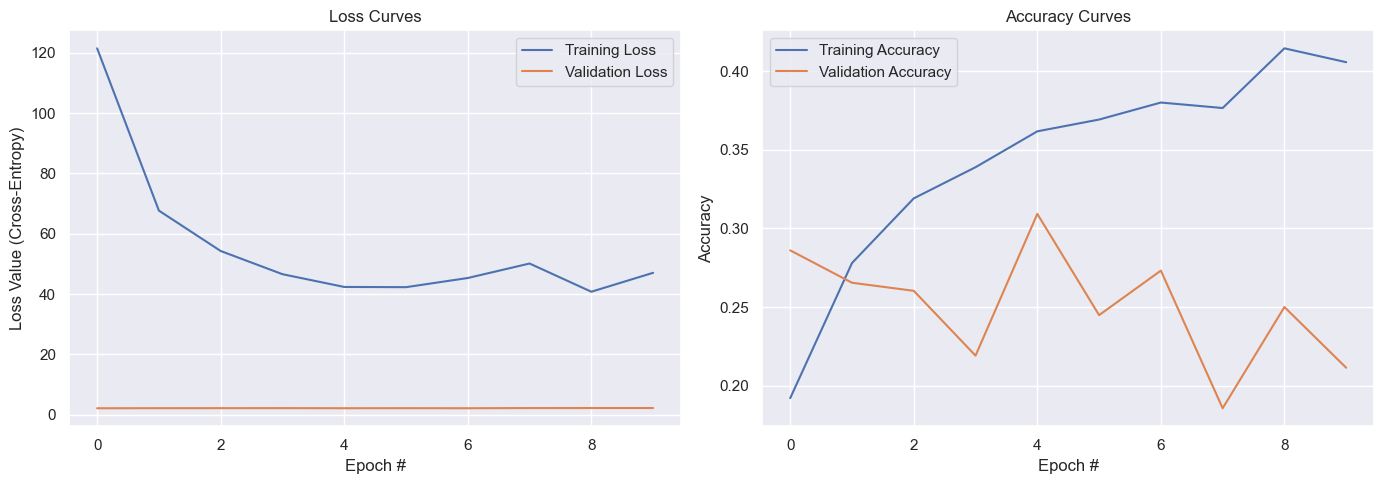

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4616 - loss: 28.9981
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3286 - loss: 2.1378 
Training accuracy:  0.449
Validation accuracy:  0.309
Generalization Gap:  0.140


In [12]:
## train model on subsetted dataset
# set random seed
import random
random.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

# build model
model1 = build_model(12288, 0.00025, num_classes=10)
print(model1.summary())

# train model
num_epochs = 10
history1 = model1.fit(
    X_train_sub,
    y_train_sub,
    validation_data=(X_val_sub, y_val_sub),
    epochs=num_epochs,
    callbacks=[early_stopping],
    batch_size=64
)

# create loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 5))

ax1.plot(history1.history['loss'], label='Training Loss')
ax1.plot(history1.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss Value (Cross-Entropy)')
ax1.legend()

ax2.plot(history1.history['accuracy'], label='Training Accuracy')
ax2.plot(history1.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()

plt.show()

train_acc = model1.evaluate(X_train_sub, y_train_sub)[1]
val_acc = model1.evaluate(X_val_sub, y_val_sub)[1]
gap = train_acc - val_acc

print(f'Training accuracy: {train_acc: .3f}')
print(f'Validation accuracy: {val_acc: .3f}')
print(f'Generalization Gap: {gap: .3f}')


### Next, we will train our model on the full dataset

In [13]:
# prep full dataset labels for training
encoder.fit(y_train)

print(y_train[0:5]) # before encoding
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)
print(y_train[0:5]) # after encoding

['irish_wolfhound' 'brittany_spaniel' 'redbone' 'boxer' 'pekinese']
[59 24 89 21 85]


In [14]:
# calculate baseline accuracy for full dataset

# get majority class of y_test dataset
majority_class = np.bincount(y_test).argmax()
print(majority_class)
print(encoder.inverse_transform([majority_class])[0])

# compute majority baseline accuracy
baseline_pred = np.full_like(y_test, fill_value=majority_class)
baseline_accuracy = np.mean(baseline_pred == y_test)
print(f"Majority Baseline Accuracy of Full Data: {baseline_accuracy:.4f}")

# compute random guessing baseline accuracy
random_preds = np.random.randint(0, 120, size=len(y_test))
random_accuracy = np.mean(random_preds == y_test)
print(f"Random Guessing Accuracy of Full Data: {random_accuracy:.4f}")

73
maltese_dog
Majority Baseline Accuracy of Full Data: 0.0177
Random Guessing Accuracy of Full Data: 0.0068


/opt/anaconda3/envs/w207_new/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │     1,474,680 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,474,680 (5.63 MB)

 Trainable params: 1,474,680 (5.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0203 - loss: 173.5062 - val_accuracy: 0.0263 - val_loss: 4.7305
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0415 - loss: 107.7951 - val_accuracy: 0.0261 - val_loss: 4.7137
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0531 - loss: 96.7015 - val_accuracy: 0.0301 - val_loss: 4.7082
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0646 - loss: 88.8485 - val_accuracy: 0.0345 - val_loss: 4.7026
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0734 - loss: 83.5407 - val_accuracy: 0.0366 - val_loss: 4.7145
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0794 - loss: 80.4792 - val_accuracy: 0.0261 - val_loss: 4.7107
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0879 - loss: 76.0869 - val_accuracy: 0.0312 - val_loss: 4.7066
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0935 - loss: 76.

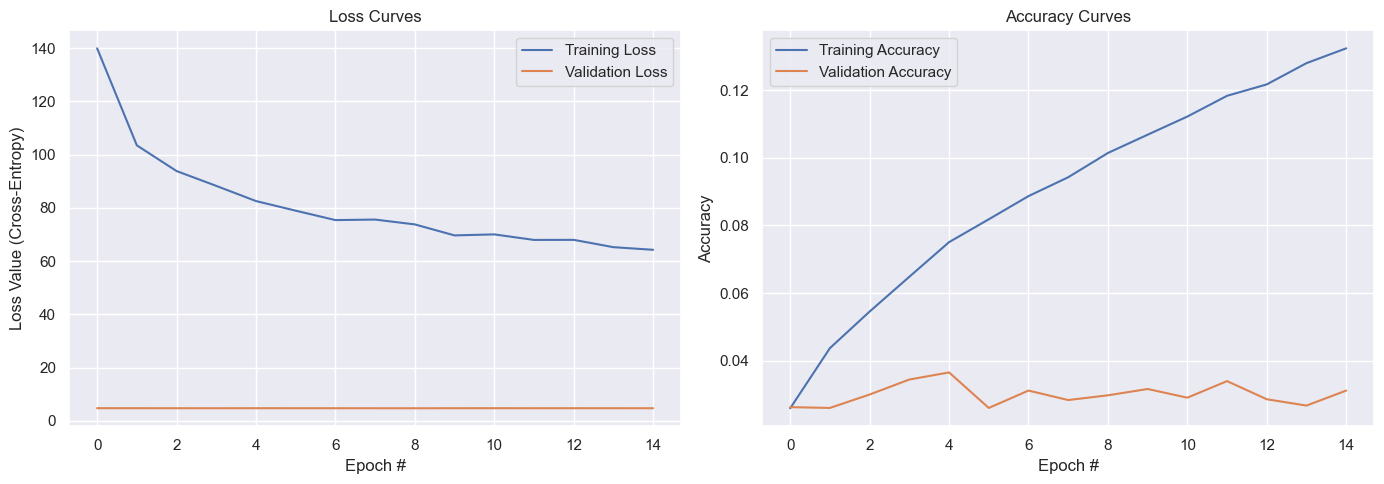

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0885 - loss: 86.6946
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0329 - loss: 4.7149
Training accuracy:  0.084
Validation accuracy:  0.037
Generalization Gap:  0.047


In [15]:
## train model on full dataset

# set random seed
import random
random.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

# build model
model2 = build_model(12288, 0.0001, num_classes=120)
print(model2.summary())

# train model
num_epochs = 100
history2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    callbacks=[early_stopping],
    batch_size=128
)

# create loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 5))

ax1.plot(history2.history['loss'], label='Training Loss')
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss Value (Cross-Entropy)')
ax1.legend()

ax2.plot(history2.history['accuracy'], label='Training Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()

plt.show()

train_acc = model2.evaluate(X_train, y_train)[1]
val_acc = model2.evaluate(X_val, y_val)[1]
gap = train_acc - val_acc

print(f'Training accuracy: {train_acc: .3f}')
print(f'Validation accuracy: {val_acc: .3f}')
print(f'Generalization Gap: {gap: .3f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


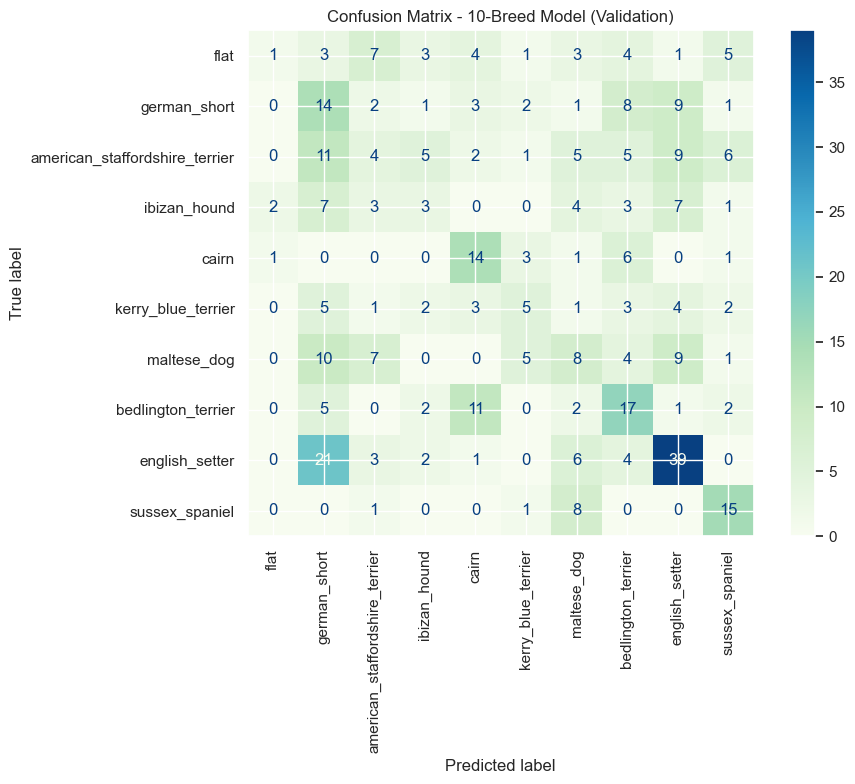

In [17]:
# Plotting Confusion Matrix for Subset Dataset
probs_val = model1.predict(X_val_sub)
y_pred_val = np.argmax(probs_val, axis=1)


cm = confusion_matrix(y_val_sub, y_pred_val)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes_sub)
disp.plot(cmap='GnBu', ax=ax, xticks_rotation=90)

plt.title("Confusion Matrix - 10-Breed Model (Validation)")
plt.tight_layout()
plt.show()

In [18]:
# Number of Mistakes from 10-breed model
mistakes = cm.sum(axis=1) - np.diag(cm)
pd.DataFrame(mistakes, columns=['mistakes'], index = classes_sub).sort_values(by=['mistakes'], ascending=False)

,mistakes
american_staffordshire_terrier,44
english_setter,37
maltese_dog,36
flat,31
german_short,27
ibizan_hound,27
bedlington_terrier,23
kerry_blue_terrier,21
cairn,12
sussex_spaniel,10


In [34]:
# Evaluate final model on test dataset

from sklearn.metrics import classification_report

probs_train = model2.predict(X_train)
probs_test = model2.predict(X_test)

y_pred_train = np.argmax(probs_train, axis=1)
y_pred_test = np.argmax(probs_test, axis=1)

train_accuracy = np.sum(y_pred_train == y_train) / len(y_train)
test_accuracy = np.sum(y_pred_test == y_test) / len(y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
gap = train_acc - val_acc
print(f'Generalization Gap: {gap: .3f}')

report = classification_report(y_test, y_pred_test, output_dict=True)
print(classification_report(y_test, y_pred_test))

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Accuracy: 0.08381944444444445
Test Accuracy: 0.03566433566433566
Generalization Gap:  0.047
              precision    recall  f1-score   support

           0       0.13      0.12      0.12        25
           1       0.17      0.03      0.05        70
           2       0.02      0.03      0.02        35
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        26
           6       0.04      0.17      0.07        48
           7       0.09      0.07      0.08        54
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        47
          10       0.09      0.10      0.10        41
          11       0.06      0.07      0.06        59
          12       0.00      0.00      0.00        29
          13       0.03      0.02      0.02        44
       

/opt/anaconda3/envs/w207_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/w207_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/w207_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaco

In [33]:
top_f1_idx = [69, 0, 73, 65, 98]
top_f1_labels = []
for i in top_f1_idx:
    top_f1_labels.append(classes[i])
    
print("Breeds with top 5 F1 Scores:", top_f1_labels)

zero_f1_idx = [
    label for label, metrics in report.items()
    if isinstance(metrics, dict) and metrics.get('f1-score', 1) == 0
]

zero_f1_idx = [int(x) for x in zero_f1_idx]

zero_f1_labels = []
for i in zero_f1_idx:
    zero_f1_labels.append(classes[i])

print("Breeds with F1 Score of 0:", zero_f1_labels)

Breeds with top 5 F1 Scores: ['leonberg', 'affenpinscher', 'maltese_dog', 'komondor', 'sealyham_terrier']
Breeds with F1 Score of 0: ['airedale', 'american_staffordshire_terrier', 'appenzeller', 'basset', 'beagle', 'black', 'border_collie', 'border_terrier', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chow', 'cocker_spaniel', 'collie', 'dandie_dinmont', 'dingo', 'english_foxhound', 'english_setter', 'eskimo_dog', 'french_bulldog', 'german_shepherd', 'german_short', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'ibizan_hound', 'irish_setter', 'irish_wolfhound', 'italian_greyhound', 'keeshond', 'labrador_retriever', 'lakeland_terrier', 'malinois', 'miniature_poodle', 'miniature_schnauzer', 'norwegian_elkhound', 'norwich_terrier', 'otterhound', 'papillon', 'pekinese', 'pembroke', 'pug', 'redbone', 'rhodesian_ridgeback', 'rottweiler', 'saint_bernard', 'samoyed', 'schipperke', 'scotch_terrier', 'shetland_

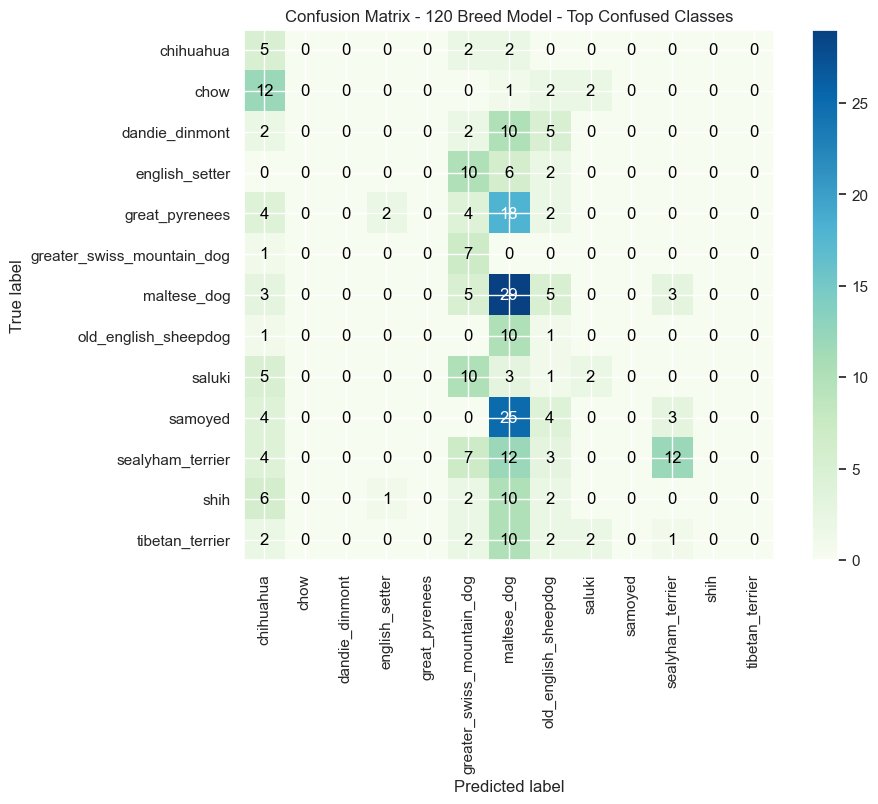

In [35]:
# Plotting Confusion Matrix for Full Dataset
# Since we have too many classes, we'll plot the top most confused classes 
cm = confusion_matrix(y_test, y_pred_test)

# Remove diagonal (correct predictions) to isolate confusion
cm_off_diag = cm.copy()
np.fill_diagonal(cm_off_diag, 0)

# Find top 10 confused class pairs (with highest off-diagonal values)
flat_indices = np.argsort(cm_off_diag.ravel())[::-1][:10]
top_confused_pairs = [np.unravel_index(i, cm.shape) for i in flat_indices]

# Get unique class labels involved in top confused pairs
top_labels = sorted(set(i for pair in top_confused_pairs for i in pair))

# Slice a smaller confusion matrix using only those top labels
cm_top = cm[np.ix_(top_labels, top_labels)]

# Plot matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_top, interpolation='nearest', cmap='GnBu')
plt.title("Confusion Matrix - 120 Breed Model - Top Confused Classes")
plt.colorbar()
tick_marks = np.arange(len(top_labels))
label_names = [classes[i] for i in top_labels]
plt.xticks(tick_marks, label_names, rotation=90
)
plt.yticks(tick_marks, label_names)

# Overlay the numbers
for i in range(len(top_labels)):
    for j in range(len(top_labels)):
        val = cm_top[i, j]
        plt.text(j, i, format(val, 'd'), ha="center", va="center",
                 color="white" if val > cm_top.max() / 2. else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [22]:
# Number of Mistakes from 120-breed model (top most confused only)
mistakes = cm_top.sum(axis=1) - np.diag(cm_top)
pd.DataFrame(mistakes, columns=['mistakes'], index = label_names).sort_values(by=['mistakes'], ascending=False)


,mistakes
samoyed,36
great_pyrenees,30
sealyham_terrier,26
shih,21
dandie_dinmont,19
saluki,19
tibetan_terrier,19
english_setter,18
chow,17
maltese_dog,16


In [24]:
top_label_names = encoder.inverse_transform(top_labels)
print("Top confused class names:", top_label_names)

Top confused class names: ['chihuahua' 'chow' 'dandie_dinmont' 'english_setter' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'maltese_dog' 'old_english_sheepdog'
 'saluki' 'samoyed' 'sealyham_terrier' 'shih' 'tibetan_terrier']


### Conclusion:

Our multi-class logistic regression models were able to perform better than baseline for both the subsetted dataset and the full dataset. As expected, we were only able to get so far with overall accuracy and generalization, since logistic regression models do not have the ability to capture spatial or hierarchical patterns in image data.

For this approach, the subsetted model overall performed much better, which aligns with our expectations. It is harder to accurately classify 120 classes vs 10 classes, especially when the model has limited capacity to learn complex patterns in image data.

---
**RESULTS**

**Model Performance on Subsetted Dataset**

- Majority Baseline Accuracy: 0.1959  
- Training Accuracy: 0.390  
- Validation Accuracy: 0.304  
- Generalization Gap: 0.086

---

**Model Performance on Full Dataset**

- Majority Baseline Accuracy: 0.0177  
- Random Guessing Accuracy: 0.0068  
- Training Accuracy: 0.445  
- Validation Accuracy: 0.051  
- Generalization Gap: 0.394